<a href="https://colab.research.google.com/github/sefeoglu/AE_Parseval_Network/blob/master/src/notebooks/ResNet_Tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wide ResNet 16_2

In [ ]:
import tensorflow as tf

# Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0001


def initial_conv(input):
  
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv2:channel:  {}".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv3 channel_axis:{} ".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, kernel_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":

    init = (32, 32,1)

    wrn_16_2 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.5)

    wrn_16_2.summary()



conv2:channel:  -1
conv3 channel_axis:-1 
Wide Residual Network-16-2 created.
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 32, 32, 16)   144         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_78 (BatchNo (None, 32, 32, 16)   64          conv2d_96[0][0]                  
__________________________________________________________________________________________________
activation_78 (Activation)      (None, 32, 32, 16)   0           batch_normalization_78[0][0]     
______________

# Data Prepare and Processing




In [ ]:
from sklearn.model_selection import train_test_split
import gzip
import pickle

import numpy as np

In [ ]:

with open('data_set.pickle', 'rb') as f:
    x = pickle.load(f)

In [ ]:
X_train, y_train,X_test, y_test, X_val, y_val = x['X_train'], x['y_train'], x['X_test'], x['y_test'], x['X_val'], x['y_val']

In [ ]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()


In [ ]:
import cv2
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(cv2.resize(row['crop'], (32,32)))
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 32, 32)

In [ ]:
X = new_data_X.astype('float32')
X.shape

(5722, 32, 32)

# Preprocessing

In [ ]:
img_rows, img_cols = X[0].shape

# transform data set
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X = X.reshape(X.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y_df = pd.DataFrame(Y_data, columns=['Label'])
y_df['Encoded'] = labelencoder.fit_transform(y_df['Label'])

In [ ]:
y_df['Label'].value_counts()

closed           1500
open             1500
partiallyOpen    1376
notVisible       1346
Name: Label, dtype: int64

In [ ]:
y_df['Encoded'].value_counts()


2    1500
0    1500
3    1376
1    1346
Name: Encoded, dtype: int64

In [ ]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y_df['Encoded'])

# Training

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping
import tensorflow

EPOCHS = 200
BS = 128
sgd = SGD(lr=0.1, momentum=0.6)

In [ ]:
wrn_16_2.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")


Finished compiling


In [ ]:
def lr_sch(epoch):
    if epoch < 30:
        return 0.1
    elif epoch < 50:
        return 0.001
    elif epoch < 60:
        return 0.001
    else:
        return 0.00001

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_sch)

In [ ]:
generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

In [ ]:
hist = wrn_16_2.fit(generator.flow(X_train, y_train, batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS,
                   callbacks = [lr_scheduler],
                   validation_data=(X_val, y_val),
                   validation_steps=X_val.shape[0] // BS,)

Epoch 1/200
36/36 [==============================] - 4s 99ms/step - loss: 1.5968 - acc: 0.2887 - val_loss: 1.5523 - val_acc: 0.3728 - lr: 0.1000
Epoch 2/200
36/36 [==============================] - 3s 85ms/step - loss: 1.5177 - acc: 0.3644 - val_loss: 1.4944 - val_acc: 0.3553 - lr: 0.1000
Epoch 3/200
36/36 [==============================] - 3s 85ms/step - loss: 1.4817 - acc: 0.3686 - val_loss: 1.5421 - val_acc: 0.3728 - lr: 0.1000
Epoch 4/200
36/36 [==============================] - 3s 85ms/step - loss: 1.4696 - acc: 0.3806 - val_loss: 1.4461 - val_acc: 0.3825 - lr: 0.1000
Epoch 5/200
36/36 [==============================] - 3s 86ms/step - loss: 1.4390 - acc: 0.3946 - val_loss: 1.4198 - val_acc: 0.4311 - lr: 0.1000
Epoch 6/200
36/36 [==============================] - 3s 85ms/step - loss: 1.4277 - acc: 0.4203 - val_loss: 1.4223 - val_acc: 0.4272 - lr: 0.1000
Epoch 7/200
36/36 [==============================] - 3s 86ms/step - loss: 1.4161 - acc: 0.4265 - val_loss: 1.4206 - val_acc: 0.403

In [ ]:
wrn_16_2.save("wrn_model.h5")

**Visualization**

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


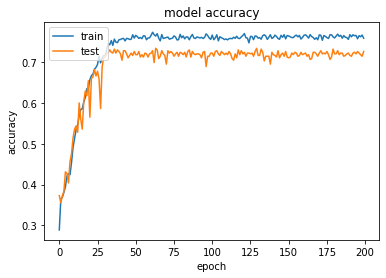

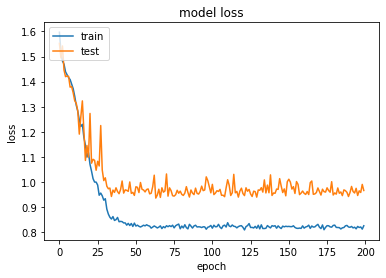

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("wrn_tensor.png")
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("deneme.png")

In [ ]:
wrn_16_2.evaluate(X_test,y_test)

18/18 [==============================] - 0s 13ms/step - loss: 0.9431 - acc: 0.7225


[0.9430834054946899, 0.7225130796432495]

# Adversarial Examples


In [ ]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())


Tensorflow Version: 2.2.0
Cleverhans Version: 3.0.1-fc7b7c7ec903258e0e3fb88503fa629f
GPU Available:  True


In [ ]:
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits

logits_model = tf.keras.Model(wrn_16_2.input,wrn_16_2.layers[-1].output)

In [ ]:
X_adv = []
epsilon_list = [0.02]
for j in range(len(epsilon_list)):
  epsilon = epsilon_list[j]
  for i in range(len(X_test)):
    random_index = i
    original_image = X_test[random_index]
    original_image = tf.convert_to_tensor(original_image.reshape((1,32,32))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    original_label = y_test[random_index]
    original_label = np.reshape(np.argmax(original_label), (1,)).astype('int64')
    adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf,y=original_label, targeted=False)
    X_adv.append(np.array(adv_example_targeted_label).reshape(32,32,1))

In [ ]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,wrn_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 12ms/step - loss: 1.0489 - acc: 0.6911
epsilon: 0.003 and test evalution : [1.0489426851272583, 0.6910994648933411]


In [ ]:
20*np.log10(np.linalg.norm(X_test)/np.linalg.norm(X_test-X_adv))

50.228538513183594

In [ ]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,wrn_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 13ms/step - loss: 1.1244 - acc: 0.6614
epsilon: 0.005 and test evalution : [1.124449372291565, 0.661431074142456]


In [ ]:
20*np.log10(np.linalg.norm(X_test)/np.linalg.norm(X_test-X_adv))

45.79124450683594

In [ ]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,wrn_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 12ms/step - loss: 1.3272 - acc: 0.5689
epsilon: 0.01 and test evalution : [1.3272491693496704, 0.5689354538917542]


In [ ]:
20*np.log10(np.linalg.norm(X_test)/np.linalg.norm(X_test-X_adv))

39.77065086364746

In [ ]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,wrn_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 13ms/step - loss: 1.7637 - acc: 0.4642
epsilon: 0.02 and test evalution : [1.7636723518371582, 0.46422338485717773]


In [ ]:
20*np.log10(np.linalg.norm(X_test)/np.linalg.norm(X_test-X_adv))

33.75005006790161

# Adversarial Training

In [ ]:
def adversarial_example(epsilon):
  X_adv = []
  for i in range(len(X_test)):
    random_index = i
    original_image = X_test[random_index]
    original_image = tf.convert_to_tensor(original_image.reshape((1,32,32))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    original_label = y_test[random_index]
    original_label = np.reshape(np.argmax(original_label), (1,)).astype('int64')
    adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf,y=original_label, targeted=False)
    X_adv.append(np.array(adv_example_targeted_label).reshape(32,32,1))
  return X_adv


**Mini batch training**

In [ ]:
""" Adversarial Training """

import numpy as np
class AdversarialTraining(object):
    """Adversarial Training  """
    def __init__(self):
        pass
    def train(self, model, X_train, pretrained_model, Y_train, epochs, batch_size, epsilon, model_type= "Parseval"):
        
        step_on_epoch = len(X_train[0]/batch_size)
        for epoch in range(0, epochs):
            for j in range(0, step_on_epoch):
                self.mini_batch_train(model,X_train, Y_train, batch_size, pretrained_model)
            ###TODO###
            ### add validation test


    def mini_batch_train(self, model, X_train,Y_train, batch_size, pretrained_model):

        x_train, y_train = self.data_augmentation(X_train, Y_train, batch_size, start_index)
        hist = model.fit(x_train, y_train, batch_size=batch_size, epochs = 1, steps_per_epoch=1)
        ### TODO ###
        ## Save hist on file.###


    def data_augmentation(self, X_train, Y_train, batch_size, pretrained_model):
      ### divide data 16,16,16,16 for 4 different epsilons and 64 is true image. ### 
        start_index = data_iteration(X_train, batch_size)
        first_half_end = start_index+batch_size/2
        second_half_end = start_index+batch_size
        x_clean, y_clean = X_train[start_index:first_half_end,:,:,:], Y_train[start_index:first_half_end]
        x_adv, y_adv = self.get_adversarial(X_train[first_half_end:second_half_end),:,:,:], Y_train[first_half_end:second_half_end], epsilon), Y_train[first_half_end:second_half_end]
        ### TODO###
        # Mixture data for 4 epsilon values
        return x_mix, y_mix

    def data_iteration(self, X_train, batch_size):
        N = x_train.shape[0]
        start = np.random.randint(0, N-batch_size)
        return start

    def get_adversarial(self, X_true, y_true, epsilon):

        return self.adversarial_example(X_true, y_true, epsilon)

    def adversarial_example(self, X_true, y_true, epsilon):
      X_adv = []
      for i in range(len(X_true)):
        random_index = i
        original_image = X_true[random_index]
        original_image = tf.convert_to_tensor(original_image.reshape((1,32,32))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
        original_label = y_true[random_index]
        original_label = np.reshape(np.argmax(original_label), (1,)).astype('int64')
        adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf,y=original_label, targeted=False)
        X_adv.append(np.array(adv_example_targeted_label).reshape(32,32,1))
      return X_adv
